In [ ]:
#https://github.com/hyukjln
#https://github.com/namu10664

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
import itertools
import numpy as np
import math

# 1. ER 네트워크에서의 보터 모델

In [ ]:
# ER 네트워크
# N개의 노드, 각각 p 확률로 연결
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))

    for i, j in itertools.combinations(G.nodes, 2):
        r = rd.random()
        if r < p:
            G.add_edge(i,j)

    return G

In [65]:
def voter_model_on_er_multiple_runs(n=100, p=0.1, initial_opinion_ratio=0.1, opinion_change_prob=0.1, max_steps=500, num_runs=1, draw_network_step=None):
    all_runs = []  # 각 실행의 평균 의견 기록

    for run in range(num_runs):
        # ER 네트워크 생성
        G = nx.gnp_random_graph(n, p)

        # 초기 의견 설정
        nums_opinion_1 = int(n*initial_opinion_ratio)
        set_opinion_1 = rd.sample(list(G.nodes()),nums_opinion_1)
        for node in G.nodes:
            if node in set_opinion_1:
                G.nodes[node]['opinion'] = 1
            else:
                G.nodes[node]['opinion'] = 0

        fixed_positions = nx.spring_layout(G) #네트워크를 그릴때 노드 위치 고정
        #네트워크 그리기
        if draw_network_step:
            draw_network_graph(G, 0, fixed_positions)

        #평균 의견 저장
        average_opinions = [np.mean([G.nodes[node]['opinion'] for node in G.nodes()])]

        for step in range(max_steps):
            G_copy = G.copy()
            #각 노드마다 확률적으로 이웃의 의견 반영
            for i in range(n):
                neighbors = list(G.neighbors(i))
                if neighbors:
                    random_neighbor = np.random.choice(neighbors)
                    if np.random.random() < opinion_change_prob:
                        G_copy.nodes[i]['opinion'] =  G.nodes[random_neighbor]['opinion']
            G = G_copy

            #평균 의견 저장
            average_opinions += [np.mean([G.nodes[node]['opinion'] for node in G.nodes()])]

            #네트워크 그리기
            if draw_network_step:
                if (step+1)%draw_network_step == 0:
                    draw_network_graph(G, step+1, fixed_positions)

            #의견이 통일되면 종료(break)
            opinion_sum = np.sum([G.nodes[node]['opinion'] for node in G.nodes()])
            if (opinion_sum == 0) or np.all(opinion_sum == 1):
                break

        all_runs.append(average_opinions)

    # 모든 실행 결과를 시각화
    plt.figure(figsize=(12, 8))
    for run in all_runs:
        plt.plot(range(len(run)), run, alpha=0.5, linewidth=0.7, color='blue')
    plt.xlabel('Time Step')
    plt.ylabel('Average Opinion')
    plt.title(f'Voter Model on ER Network - {num_runs} Runs')
    plt.show()

#네트워크를 그리는 함수
def draw_network_graph(G, step, fixed_positions):
    colors = ['red' if G.nodes[node]['opinion'] == 1 else 'blue' for node in G.nodes()]
    plt.figure(figsize=(5, 5))
    nx.draw(G, node_color=colors, pos =  fixed_positions, node_size=15, font_color='white')
    plt.title(f"Voter Model step {step}")
    plt.show()

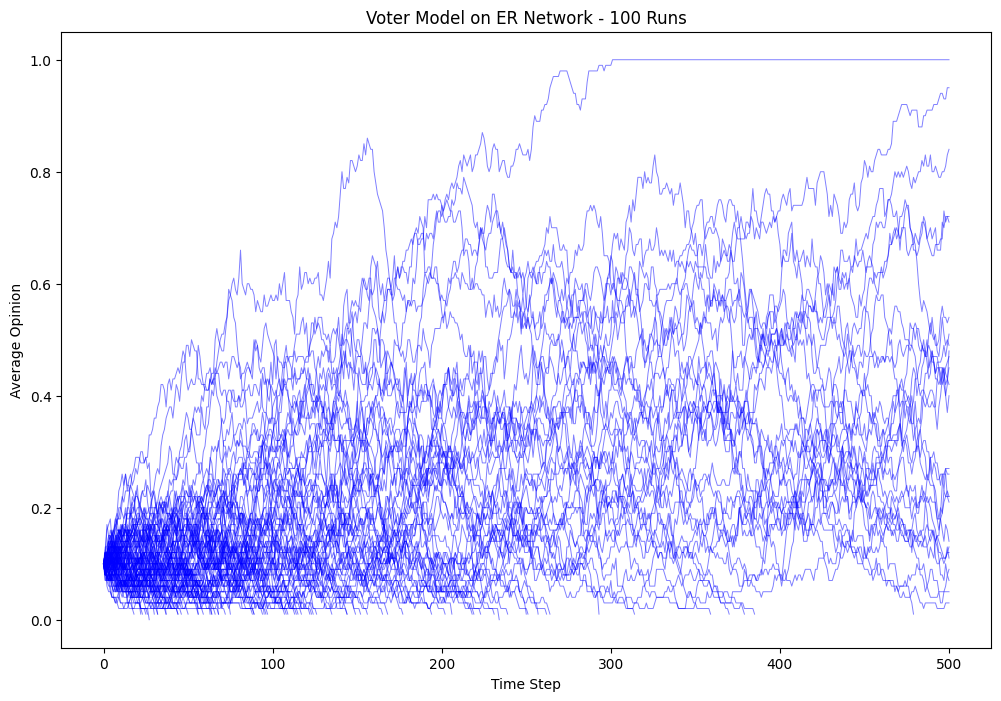

In [ ]:
# 함수 실행 (100번 반복)
voter_model_on_er_multiple_runs(num_runs=100)

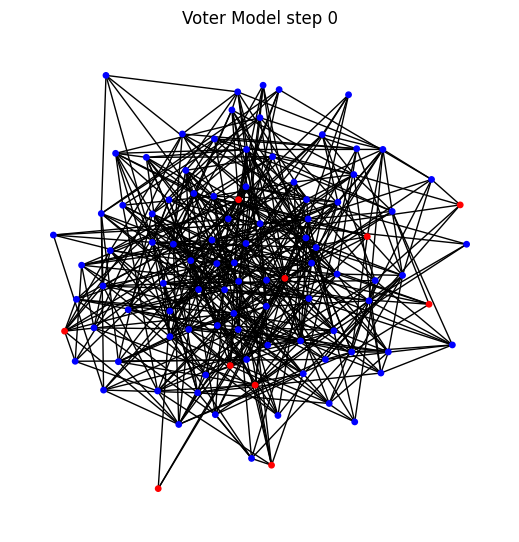

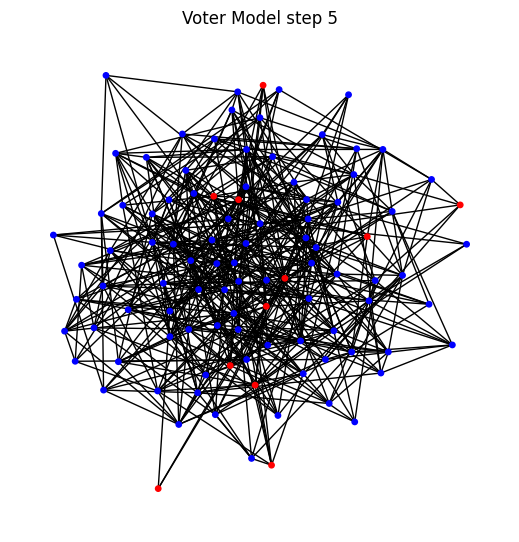

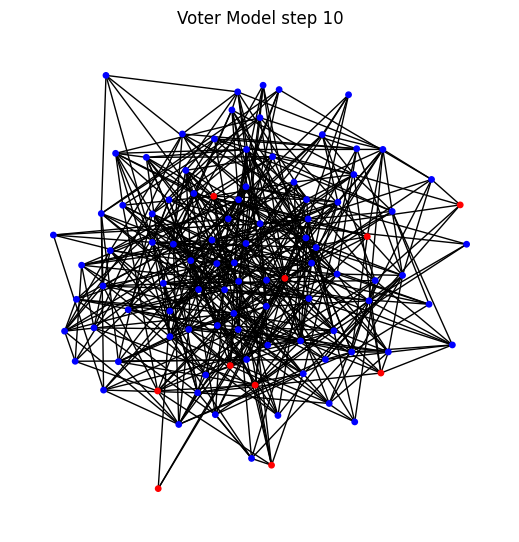

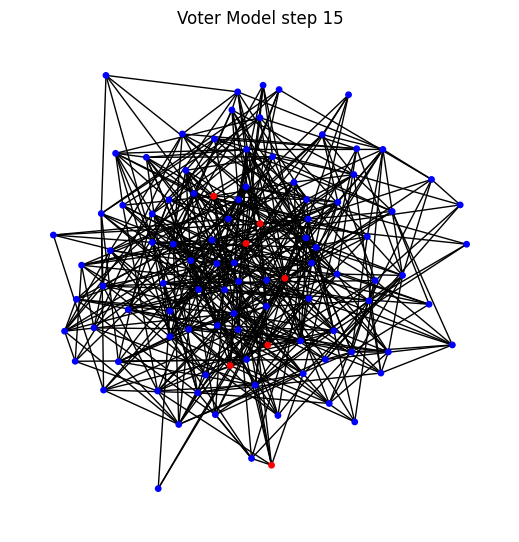

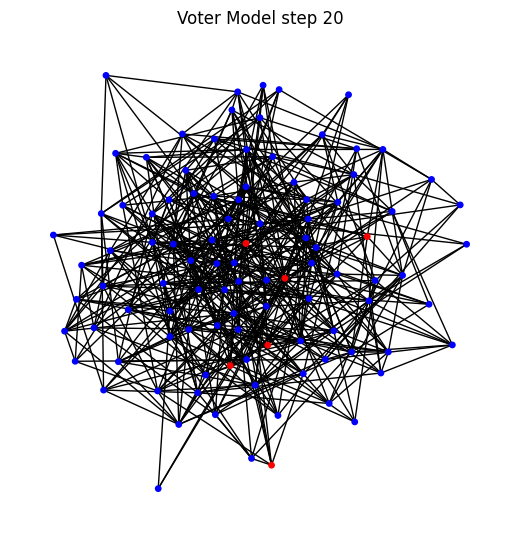

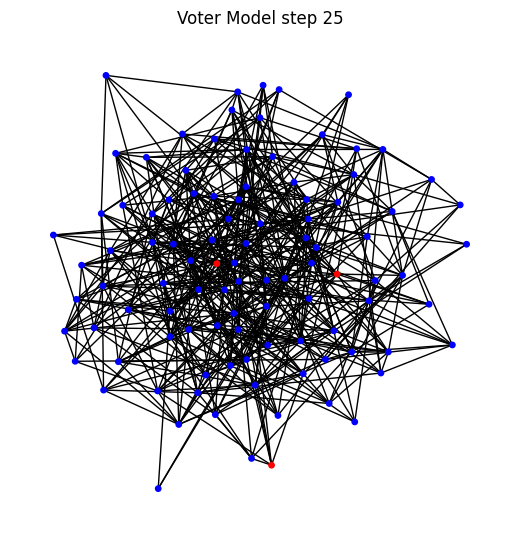

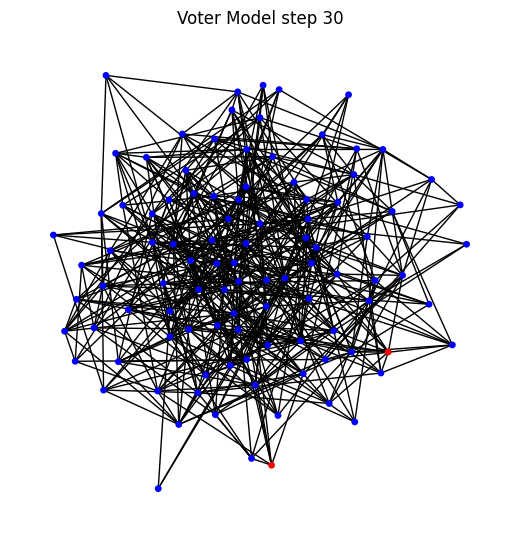

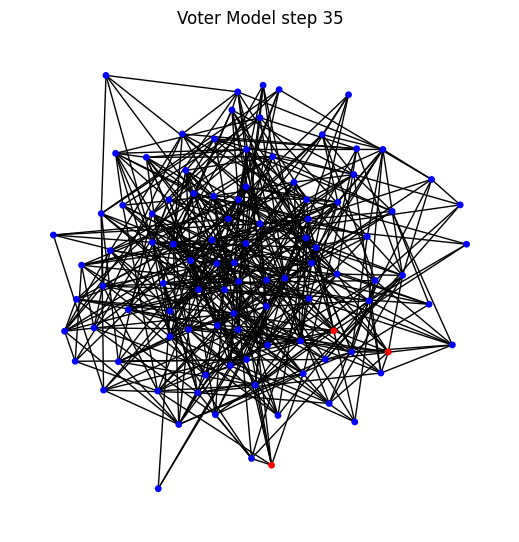

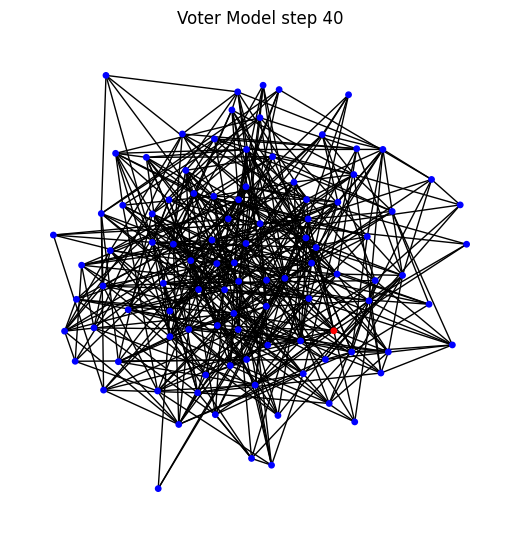

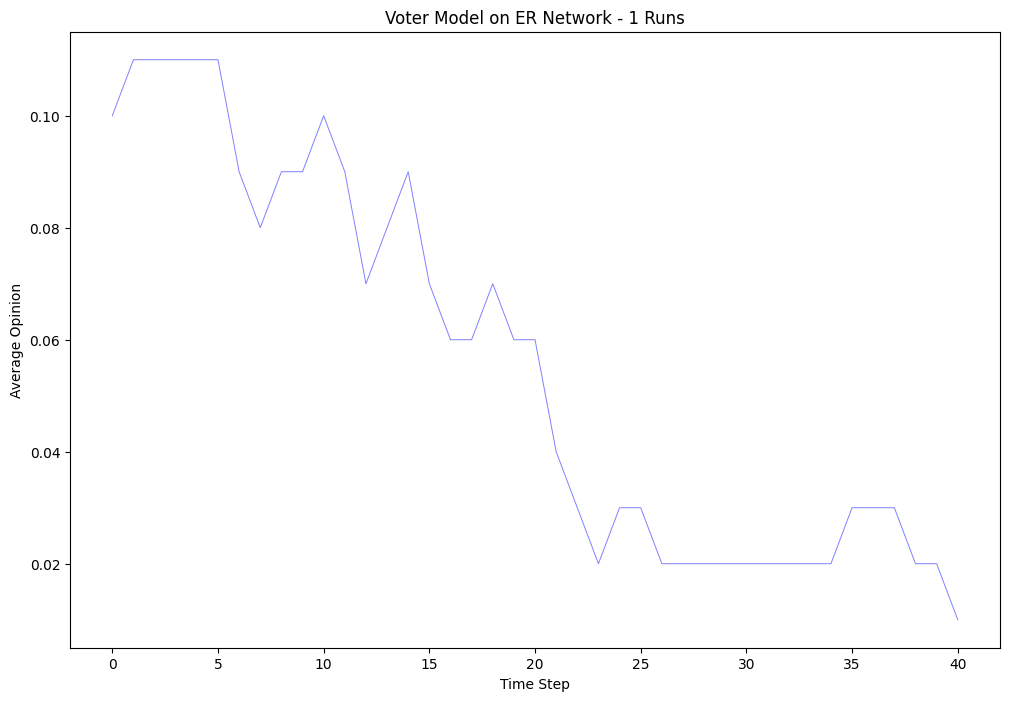

In [66]:
# 함수 실행 (네트워크 그리기)
voter_model_on_er_multiple_runs(max_steps=100, draw_network_step=5)

# 2. ER 네트워크의 이웃수분포

In [113]:
#포아송 분포를 그리는 함수

#n 노드 수, p 연결 확률
def mean_degree_c(p,n):
  return p * (n) #p * (n - 1)

#m은 실제 차수
def Poisson(m,n,p):
  c = mean_degree_c(p,n)
  return (c**m)/math.factorial(m) * math.exp(-c)

In [41]:
#er그래프를 반복 함수
def er_ensemble(n,p, ensemble):
  all_degrees = []
  # ensemble만큼 G의 degrees를 리스트에 추가한다.
  for _ in range(ensemble):
      G = gnp_random_graph(n,p)
      degrees = [G.degree(node) for node in G.nodes()]
      all_degrees += degrees

  #normalize
  degree_dic={}
  for i in range(max(all_degrees)):
    degree_dic[i] = all_degrees.count(i)/len(all_degrees)

  #포아송 분포
  Poisson_list=[]
  for m in range(i+1):
    Poisson_list.append(Poisson(m,n,p))

  return list(degree_dic.keys()), list(degree_dic.values()), Poisson_list

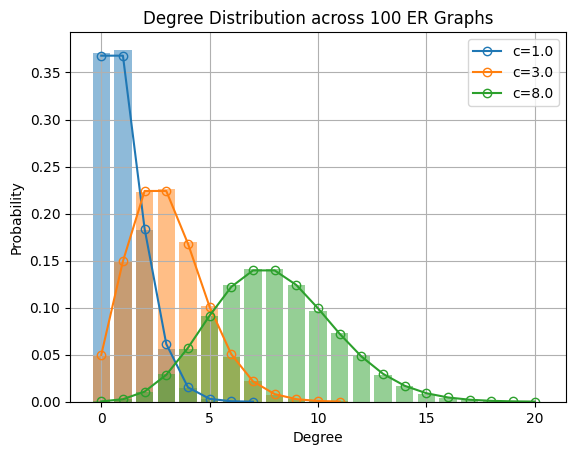

In [45]:
def ER_dist_poisson(set_values, ensembles):
  ensembles=100
  for n,p,color_i in set_values:
      c = mean_degree_c(p,n)

      x_l,y_l,p_l = er_ensemble(n,p,ensembles)
      plt.plot(x_l,p_l, label='c='+str(c), color=color_i, marker='o', markerfacecolor='none')
      plt.bar(x_l,y_l,alpha=0.5, color=color_i)
  plt.title(f"Degree Distribution across {ensembles} ER Graphs")
  plt.xlabel("Degree")
  plt.ylabel("Probability")
  plt.legend()
  plt.grid(True)
  plt.show()

#[[N_1,P_1,color_1], [N_2,P_2,color_2]]
set_values = [[100,0.01,'C0'],[300,0.01,'C1'],[800,0.01,'C2']]
ER_dist_poisson(set_values, 100)

# 3. ER 네트워크 mean geodesic distance 분포

In [115]:
# mean geodesic distance

def er_avg_dis(N, p, ensemble, BINS=0.01):
  avg_dis_list=[]
  for t in range(ensemble):
      G = gnp_random_graph(N,p)
      G_sh_paths = list(nx.shortest_path_length(G))

      sum_dis=0
      for i,j in G_sh_paths:
        sum_dis += sum(j.values()) #i노드의 모든 최단거리 합

      avg_dis=sum_dis/(N*(N-1)) #모든 최단거리들의 합/최단거리의 총 수
      avg_dis_list.append(avg_dis)

  #일정한 굵기로 히스토그램을 만든다
  hist, bin_edges = np.histogram(avg_dis_list, bins=np.arange(min(avg_dis_list), max(avg_dis_list)+BINS,BINS))
  return hist/np.sum(hist), bin_edges, np.mean(avg_dis_list)

Average Mean Geodesic Distance p=0.1: 2.2351
Average Mean Geodesic Distance p=0.2: 1.8154
Average Mean Geodesic Distance p=0.3: 1.7003
Average Mean Geodesic Distance p=0.4: 1.5988
Average Mean Geodesic Distance p=0.5: 1.5005
Average Mean Geodesic Distance p=0.6: 1.3995
Average Mean Geodesic Distance p=0.7: 1.3000
Average Mean Geodesic Distance p=0.8: 1.2000
Average Mean Geodesic Distance p=0.9: 1.0991
Average Mean Geodesic Distance p=1.0: 1.0000


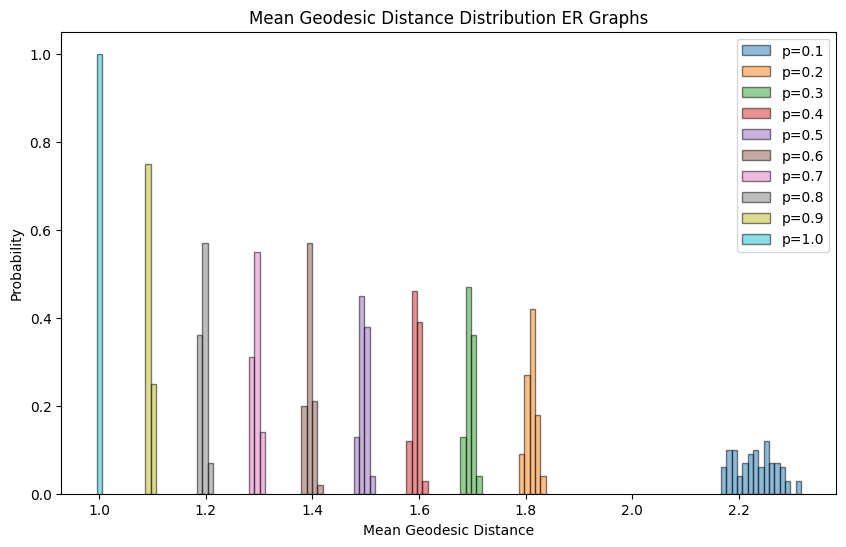

In [52]:
plt.figure(figsize=(10, 6))

for i in range(1,11):
  p=i/10
  hist, bin_edges, mean_distances = er_avg_dis(N=100, p=p, ensemble=100, BINS=0.01)
  plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", alpha=0.5, label='p='+str(p))
  print(f"Average Mean Geodesic Distance p={p}: {mean_distances:.4f}")

plt.title('Mean Geodesic Distance Distribution ER Graphs')
plt.xlabel("Mean Geodesic Distance")
plt.ylabel('Probability')
plt.legend()
plt.show()

# 4. ER 네트워크 giant component 크기 변화

In [55]:
#component의 크기를 구하기 위해 DFS함수를 사용

def DFS(G, u, visited = None):
  if visited is None:
    visited = []

  visited.append(u)                  # u를 visited 로 저장

  for next in G[u]:                  # u에서 갈 수 있는 모든 노드들에 대해서도 DFS함수를 실행
    if next not in visited:          # 단, 그 노드들은 visited에 포함되않은 노드
      DFS(G,next,visited)   #재귀함수
  return visited

In [54]:
def er_giant_component(N, p_max, p_step, ensemble):
    result=[]

    p_max_f= int(p_max/p_step)
    for pi in range(0,p_max_f): #설정한 p의 범위로 실행함
        p = pi*p_step

        max_comp_length_list=[]
        for t in range(ensemble):
            G = gnp_random_graph(N,p)
            edge_dic={}
            for n in G.nodes:
              edge_dic[n] = [j for i,j in G.edges(n)]

            checked=set()
            max_comp_length=0
            for n in G.nodes: #그래프의 모든 노드로 DFS를 시작함
              if n not in checked: #이미 확인한 노드이면 pass
                compo = DFS(edge_dic, n)
                checked.update(compo) #확인한 노드로 checked에 추가

                if len(compo) > max_comp_length: #len(compo)은 componant의 크기
                  max_comp_length = len(compo)

            max_comp_length_list.append(max_comp_length)
        #normalize
        result.append(sum(max_comp_length_list)/ensemble/N)
    return result

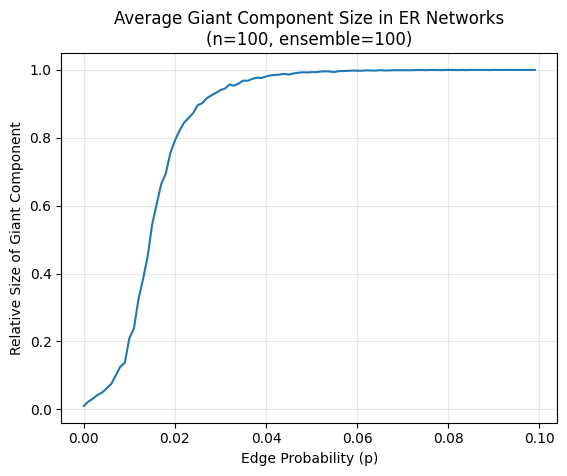

In [56]:
N = 100
p_max = 0.1 #(0~0.1까지)
p_step = 0.001
ensemble = 100

r = er_giant_component(N, p_max, p_step, ensemble)
plt.plot([p/1000 for p in range(int(p_max/p_step))], r)
plt.title(f"Average Giant Component Size in ER Networks\n(n={N}, ensemble={ensemble})")
plt.xlabel("Edge Probability (p)")
plt.ylabel("Relative Size of Giant Component")
plt.grid(True, alpha=0.3)

총 노드 수: 100
총 엣지 수: 107
평균 연결 수: 2.14
컴포넌트 수: 12
컴포넌트 크기: 87


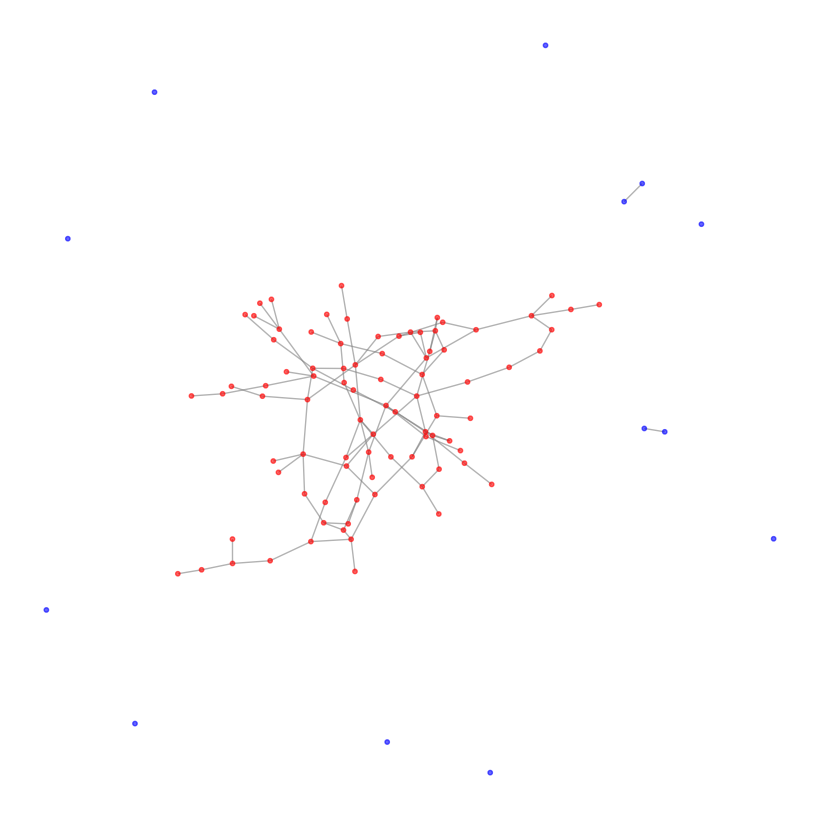

In [110]:
def visualize_componant(N=100, p=0.1):
    G = gnp_random_graph(N,p)
    edge_dic={}
    for n in G.nodes:
      edge_dic[n] = [j for i,j in G.edges(n)]

    checked=set()
    big_compo=[]
    max_comp_length,compo_num=0,0
    for n in G.nodes: #그래프의 모든 노드로 DFS를 시작함
      if n not in checked: #이미 확인한 노드이면 pass
        compo_num+=1
        compo = DFS(edge_dic, n)
        checked.update(compo) #확인한 노드로 checked에 추가

        if len(compo) > max_comp_length: #len(compo)은 componant의 크기
          max_comp_length = len(compo)
          big_compo = compo

    plt.figure(figsize=(8, 8))
    colors = ['red' if node in big_compo else 'blue' for node in G.nodes()]
    nx.draw(G, node_color=colors, node_size=10, edge_color='gray', alpha=0.6)

    print(f"총 노드 수: {G.number_of_nodes()}")
    print(f"총 엣지 수: {G.number_of_edges()}")
    print(f"평균 연결 수: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    print(f"컴포넌트 수: {compo_num}")
    print(f"컴포넌트 크기: {max_comp_length}")
# 함수 실행
visualize_componant(p=0.02)

# 5. ER, configuration model, chung-lu, BA 모형의 랜덤 네트워크 생성

## ER model

In [71]:
def gnp_random_graph(n, p):# N개의 노드, 각각 p 확률로 연결
    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i, j in itertools.combinations(G.nodes, 2):
        r = rd.random()
        if r < p:
            G.add_edge(i,j)

    return G

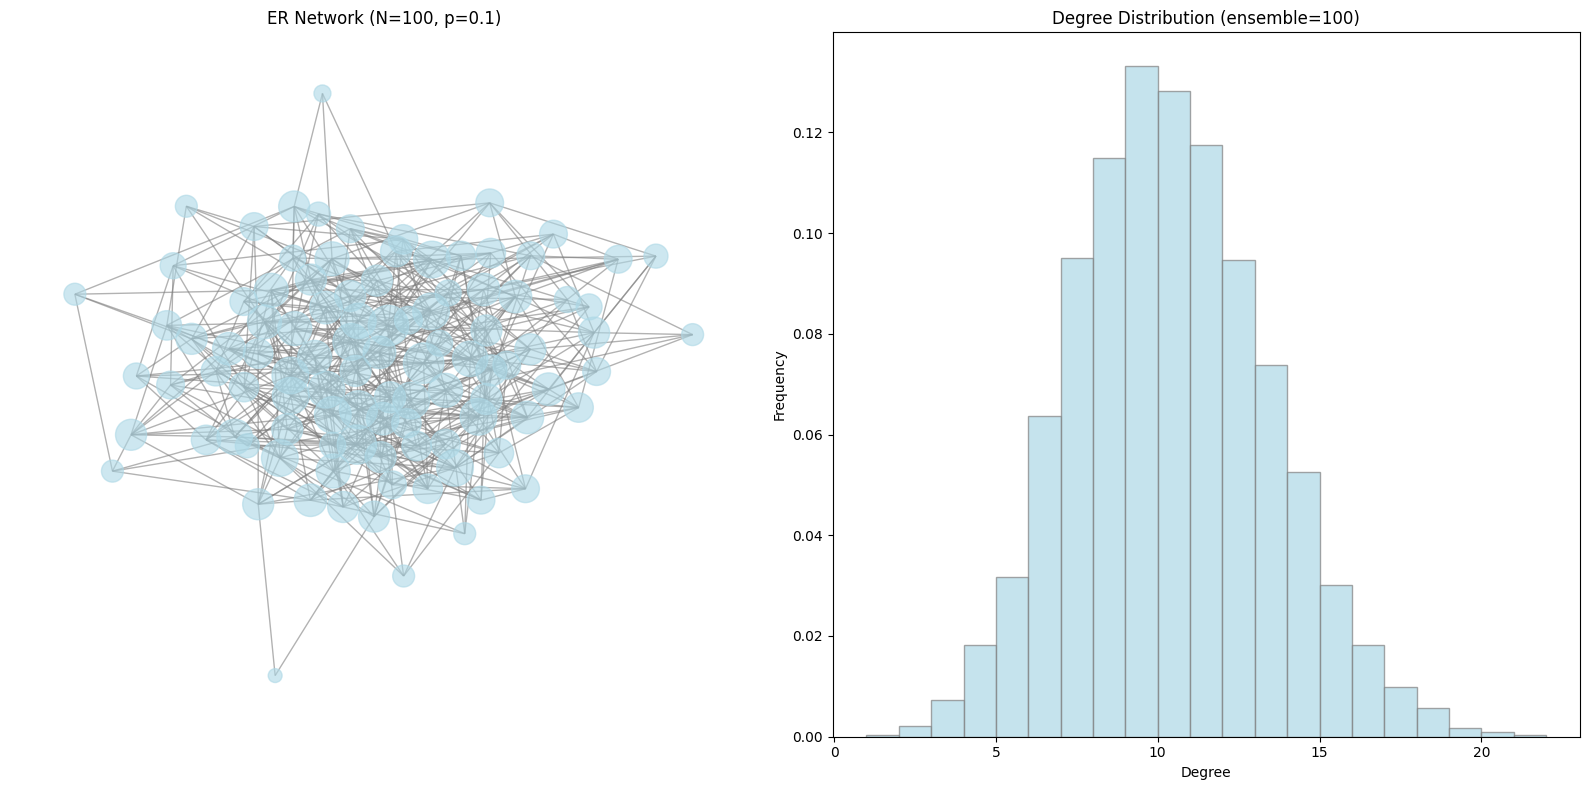

총 노드 수: 100
총 엣지 수: 476
평균 연결 수: 9.52


In [73]:
def visualize_network_ER(p=0.1, n=100, ensemble=100):
    # ER 모델 네트워크 생성
    G = gnp_random_graph(n, p)

    # 노드 크기를 차수에 따라 설정
    node_sizes = [d * 50 for _, d in G.degree()]

    # 네트워크 시각화
    plt.figure(figsize=(16, 8))

    # (1) 네트워크 그래프 시각화
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(G)  # 스프링 레이아웃
    nx.draw(
        G, pos, node_size=node_sizes, node_color='lightblue',
        edge_color='gray', alpha=0.6
    )
    plt.title(f"ER Network (N={n}, p={p})")

    # (2) 노드별 차수 히스토그램
    degrees = [d for _, d in G.degree()]
    for i in range(ensemble-1):
      G = gnp_random_graph(n, p)
      degrees += [d for _, d in G.degree()]
    plt.subplot(1, 2, 2)
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), color='lightblue', alpha=0.7, edgecolor='gray',density=True)
    plt.title(f"Degree Distribution (ensemble={ensemble})")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")

    # 그래프 출력
    plt.tight_layout()
    plt.show()

    # 연결 정보 출력
    print(f"총 노드 수: {G.number_of_nodes()}")
    print(f"총 엣지 수: {G.number_of_edges()}")
    print(f"평균 연결 수: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
# 함수 실행
visualize_network_ER()

## (karate_club_graph)

Text(0, 0.5, 'Frequency')

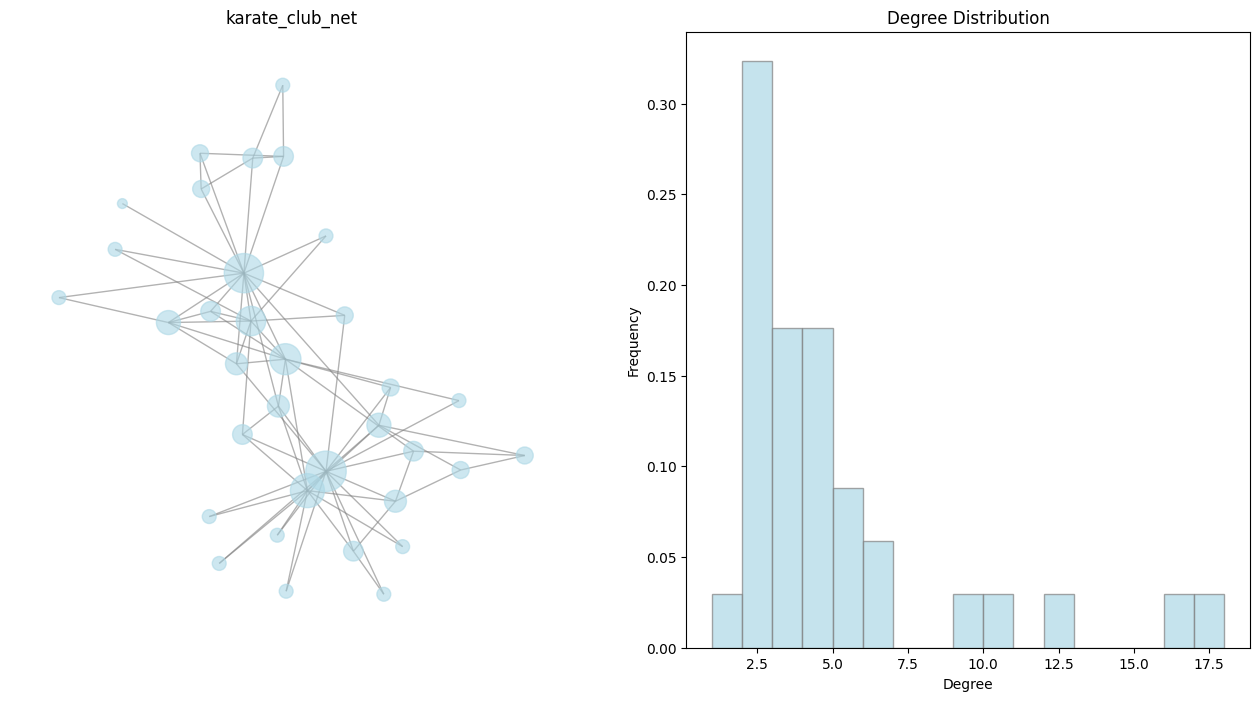

In [97]:
karate_net = nx.karate_club_graph()

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
nx.draw(
    karate_net,node_size=[d * 50 for _, d in karate_net.degree()], node_color='lightblue',
    edge_color='gray', alpha=0.6)
plt.title("karate_club_net")

plt.subplot(1, 2, 2)
degrees = [d for _, d in karate_net.degree()]
plt.subplot(1, 2, 2)
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), color='lightblue', alpha=0.7, edgecolor='gray',density=True)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")

## configuration model

In [75]:
def create_config_graph(degree_seq):

  #연결이 있는 노드들을 연결 수만큼 stub_list에 저장
  stub_list = []
  for node,degree in enumerate(degree_seq):
    stub_list.extend([node]*degree)

  rd.shuffle(stub_list)

  config_graph=nx.Graph()
  config_graph.add_nodes_from(range(len(degree_seq))) #degree_seq와 같은 노드 수만큼 노드를 만듦

  while len(stub_list)>1:
    #두 개의 노드를 뽑는다
    node1=stub_list.pop()
    node2=stub_list.pop()

    #두 노드가 같은 노드이면 다시 선택
    while node1 == node2 and len(stub_list)>0:
      stub_list.append(node2)
      rd.shuffle(stub_list)
      node2=stub_list.pop()

    #연결
    if node1 != node2:
      config_graph.add_edge(node1,node2)

  return config_graph

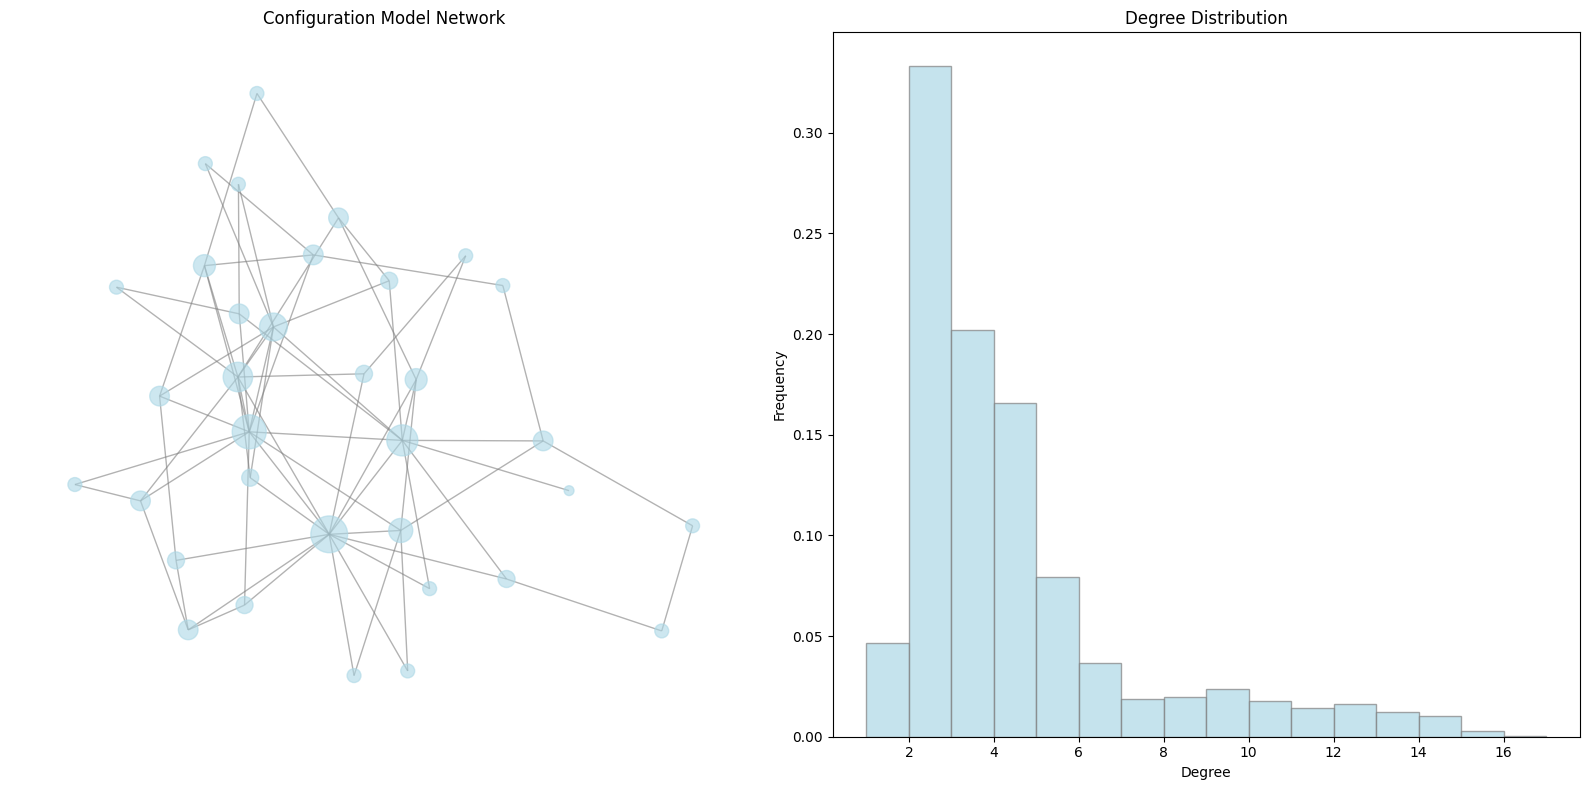

총 노드 수: 34
총 엣지 수: 65
평균 연결 수: 3.82


In [86]:
def visualize_network_config(degree_seq,ensemble=100):

    # Configuration 모델 네트워크 생성
    G = create_config_graph(degree_seq)

    # 노드 크기를 차수에 따라 설정
    node_sizes = [d * 50 for _, d in G.degree()]

    # 네트워크 시각화
    plt.figure(figsize=(16, 8))

    # (1) 네트워크 그래프 시각화
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(G)  # 스프링 레이아웃
    nx.draw(
        G, pos, node_size=node_sizes, node_color='lightblue',
        edge_color='gray', alpha=0.6
    )
    plt.title("Configuration Model Network")

    # (2) 노드별 차수 히스토그램
    degrees = [d for _, d in G.degree()]
    for i in range(ensemble-1):
      G = create_config_graph(degree_seq)
      degrees += [d for _, d in G.degree()]
    plt.subplot(1, 2, 2)
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), color='lightblue', alpha=0.7, edgecolor='gray',density=True)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")

    # 그래프 출력
    plt.tight_layout()
    plt.show()

    # 연결 정보 출력
    print(f"총 노드 수: {G.number_of_nodes()}")
    print(f"총 엣지 수: {G.number_of_edges()}")
    print(f"평균 연결 수: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")

# 함수 실행
karate_net = nx.karate_club_graph()
karate_degrees = [d for _, d in karate_net.degree()]

visualize_network_config(karate_degrees)

## chung-lu model

In [80]:
def create_chung_lu_net(degree_seq):
  n = len(degree_seq)
  chunglu_net = nx.Graph()
  chunglu_net.add_nodes_from(range(n))

  for i in range(n):
    for j in range(i+1,n):
      #(i의 degree*j의 degree)/전체 degree 를 확률로 함
      p_ij = (degree_seq[i]*degree_seq[j])/sum(degree_seq)

      #p_ij확률로 연결
      if p_ij > rd.random():
        chunglu_net.add_edge(i,j)
  return chunglu_net

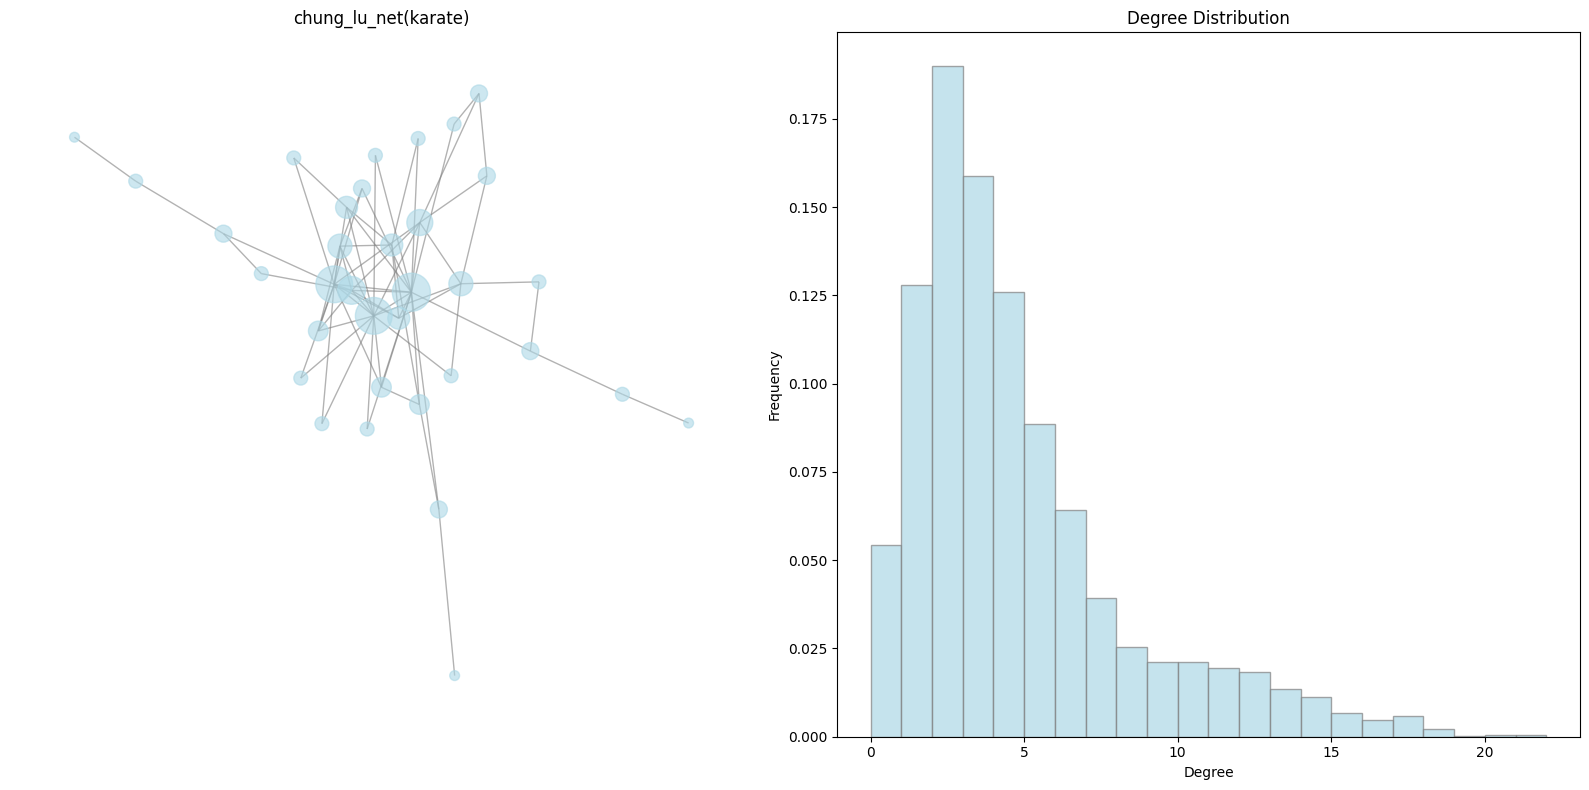

총 노드 수: 34
총 엣지 수: 54
평균 연결 수: 3.18


In [85]:
def visualize_network_chung_lu(degree_seq,ensemble=100):

    # Configuration 모델 네트워크 생성
    G = create_chung_lu_net(degree_seq)

    # 노드 크기를 차수에 따라 설정
    node_sizes = [d * 50 for _, d in G.degree()]

    # 네트워크 시각화
    plt.figure(figsize=(16, 8))

    # (1) 네트워크 그래프 시각화
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(G)  # 스프링 레이아웃
    nx.draw(
        G, pos, node_size=node_sizes, node_color='lightblue',
        edge_color='gray', alpha=0.6
    )
    plt.title("chung_lu_net(karate)")

    # (2) 노드별 차수 히스토그램
    degrees = [d for _, d in G.degree()]
    for i in range(ensemble-1):
      G = create_chung_lu_net(degree_seq)
      degrees += [d for _, d in G.degree()]
    plt.subplot(1, 2, 2)
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), color='lightblue', alpha=0.7, edgecolor='gray',density=True)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")

    # 그래프 출력
    plt.tight_layout()
    plt.show()

    # 연결 정보 출력
    print(f"총 노드 수: {G.number_of_nodes()}")
    print(f"총 엣지 수: {G.number_of_edges()}")
    print(f"평균 연결 수: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")

# 함수 실행
karate_net = nx.karate_club_graph()
karate_degrees = [d for _, d in karate_net.degree()]

visualize_network_chung_lu(karate_degrees)

## BA model

In [91]:
def ba_model(n, m):
    # 초기 그래프 생성 (m+1개의 노드로 시작)
    G = nx.complete_graph(m+1)

    # 나머지 노드들 추가
    for i in range(m+1, n):
        # 각 노드의 연결 확률 계산
        degrees = [d for _, d in G.degree()]
        total_degree = sum(degrees)
        probabilities = [d/total_degree for d in degrees]

        # m개의 노드 선택 (중복 없이)
        targets = np.random.choice(list(G.nodes()), size=m, replace=False,p=probabilities)

        # 새로운 노드를 선택된 노드들과 연결
        G.add_node(i)
        for target in targets:
            G.add_edge(i, target)

    return G

노드 수: 100
엣지 수: 197
평균 연결 수: 3.94


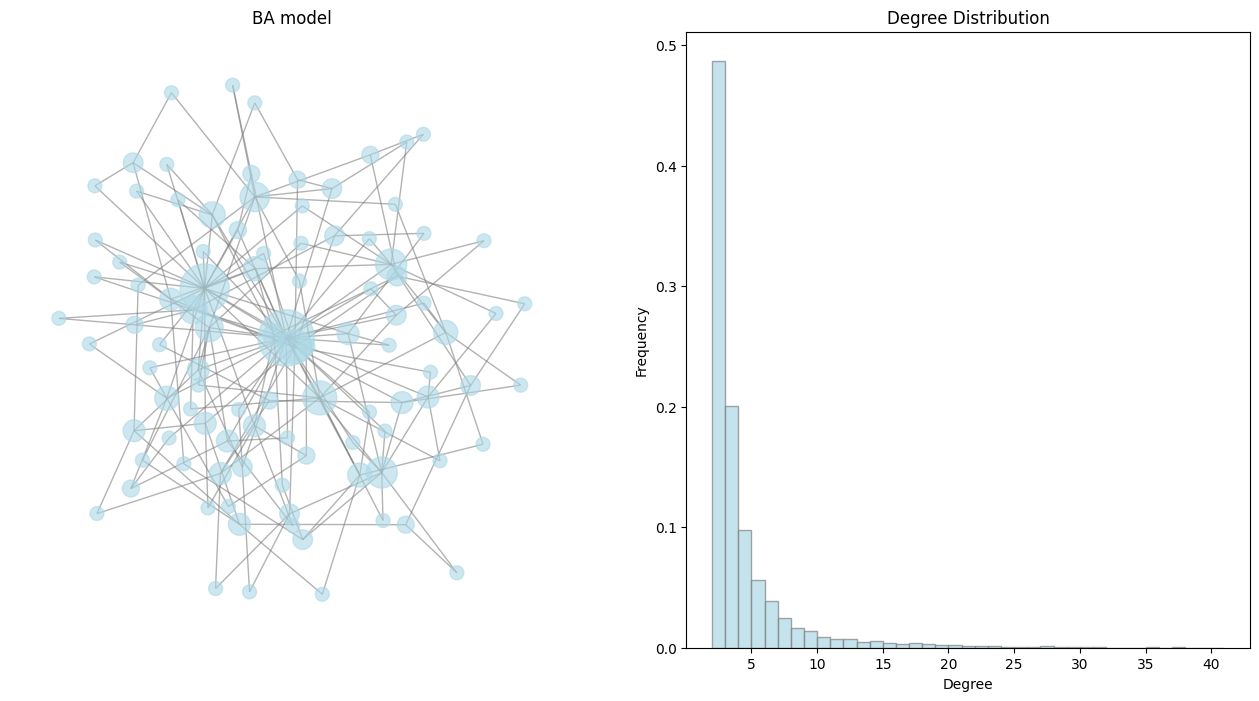

In [92]:
def visualize_ba_network(n=100, m=2):
    G = ba_model(n, m)

    node_sizes = [d * 50 for _, d in G.degree()]
    # 네트워크 시각화
    plt.figure(figsize=(16, 8))

    # (1) 네트워크 그래프 시각화
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(G)  # 스프링 레이아웃
    nx.draw(
        G, pos, node_size=node_sizes, node_color='lightblue',
        edge_color='gray', alpha=0.6
    )
    plt.title("BA model")

    # (2) 노드별 차수 히스토그램
    degrees = [d for _, d in G.degree()]
    for i in range(ensemble-1):
      G = ba_model(n, m)
      degrees += [d for _, d in G.degree()]
    plt.subplot(1, 2, 2)
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), color='lightblue', alpha=0.7, edgecolor='gray',density=True)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")

    # 네트워크 통계 출력
    print(f"노드 수: {G.number_of_nodes()}")
    print(f"엣지 수: {G.number_of_edges()}")
    print(f"평균 연결 수: {2*G.number_of_edges()/G.number_of_nodes():.2f}")

# 함수 실행
visualize_ba_network()

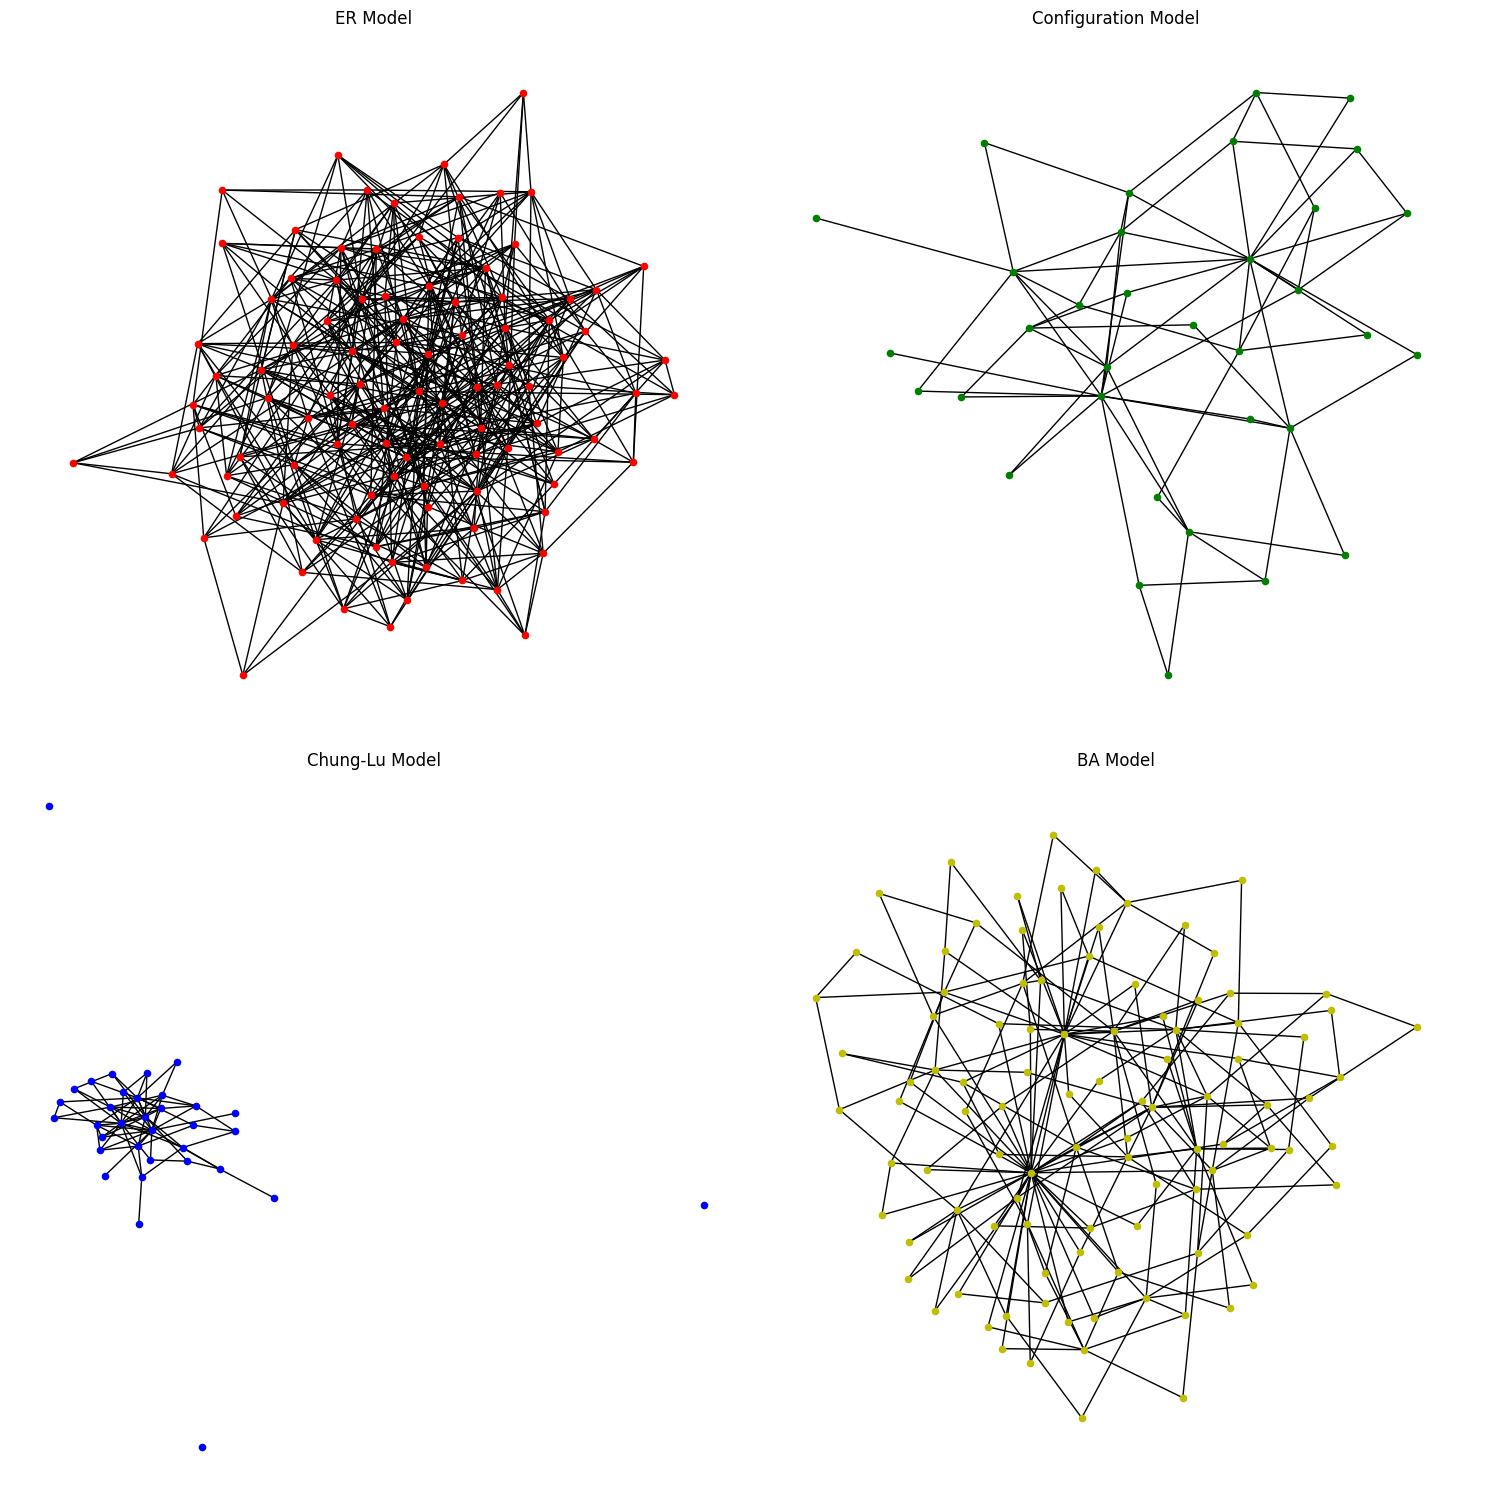

In [93]:
def generate_random_networks(degree_seq, n=100, p=0.1, m=2):
    # ER 모델
    G_er = gnp_random_graph(n, p)

    # Configuration 모델
    G_config = create_config_graph(degree_seq)

    # Chung-Lu 모델
    G_chunglu = create_chung_lu_net(degree_seq)

    # BA 모델
    G_ba = ba_model(n, m)

    # 시각화
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    pos_er = nx.spring_layout(G_er)
    nx.draw(G_er, pos_er, ax=axs[0, 0], node_size=20, node_color='r', with_labels=False)
    axs[0, 0].set_title('ER Model')

    pos_config = nx.spring_layout(G_config)
    nx.draw(G_config, pos_config, ax=axs[0, 1], node_size=20, node_color='g', with_labels=False)
    axs[0, 1].set_title('Configuration Model')

    pos_chunglu = nx.spring_layout(G_chunglu)
    nx.draw(G_chunglu, pos_chunglu, ax=axs[1, 0], node_size=20, node_color='b', with_labels=False)
    axs[1, 0].set_title('Chung-Lu Model')

    pos_ba = nx.spring_layout(G_ba)
    nx.draw(G_ba, pos_ba, ax=axs[1, 1], node_size=20, node_color='y', with_labels=False)
    axs[1, 1].set_title('BA Model')

    plt.tight_layout()
    plt.show()

generate_random_networks(karate_degrees)

In [99]:
def create_CCDF(G):
  ks = list(dict(G.degree()).values())
  k_dic,ccdf,s={},[],0
  for i in range(0, max(ks)+1):
    k_dic[i] = ks.count(i)
  for k in k_dic:
    ccdf.append(1 - s/sum(k_dic.values()))
    s+= k_dic[k]

  return ccdf

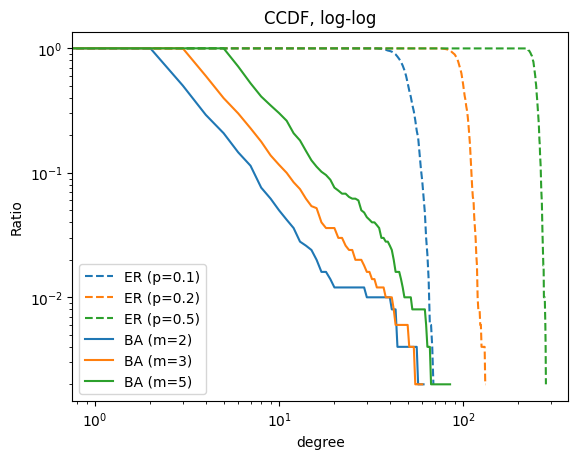

In [104]:
#ER과 BA의 CCDF

G = gnp_random_graph(500, 0.1)
ccdf_er = create_CCDF(G)
plt.plot(ccdf_er,label='ER (p=0.1)', linestyle='dashed', c='C0')

G = gnp_random_graph(500, 0.2)
ccdf_er = create_CCDF(G)
plt.plot(ccdf_er,label='ER (p=0.2)', linestyle='dashed', c='C1')

G = gnp_random_graph(500, 0.5)
ccdf_er = create_CCDF(G)
plt.plot(ccdf_er,label='ER (p=0.5)', linestyle='dashed', c='C2')

G = ba_model(500, 2)
ccdf_ba = create_CCDF(G)
plt.plot(ccdf_ba,label='BA (m=2)', c='C0')

G = ba_model(500, 3)
ccdf_ba = create_CCDF(G)
plt.plot(ccdf_ba,label='BA (m=3)', c='C1')

G = ba_model(500, 5)
ccdf_ba = create_CCDF(G)
plt.plot(ccdf_ba,label='BA (m=5)', c='C2')

plt.title('CCDF, log-log')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('Ratio')
plt.legend()
plt.show()

#BA는 비교적 선형적인 모습임